In [1]:
import numpy as np
import pandas as pd
import os
import re
import ast
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

os.chdir('/home/anovax/open_data/edrsr_data')

os.getcwd()

'/home/anovax/open_data/edrsr_data'

In [2]:
# now that we have extracted basic data we can work with, we need to create some valuable features from them
# first let's load our data

court_data = pd.read_csv('most_recent/court_features_v3.csv')
companies_data = pd.read_csv('most_recent/companies_features_v2.csv')

In [4]:
# converting the raw strings to lists
court_data['parties'] = court_data.cleaned.apply(ast.literal_eval)
court_data['outcomeFull'] = court_data.outcomeFull.apply(ast.literal_eval)

del court_data['cleaned']

AttributeError: 'DataFrame' object has no attribute 'cleaned'

In [6]:
court_data.head()

,court_code,instance,judgment_code,category_code,cause_num,adjudication_date,judge,id,outcome,outcomeFull,length,n_judges,judges_names,sex,parties
0,5008,Перша,3.0,12276.0,907/784/17,2017-12-18 00:00:00+02,Бобрик Г.Й.,71349142.0,Матеріальне,"[{'lawsuitDate': '2018-11-25T22:00:00.000Z', '...",22616.0,1.0,"[""Бобрик Ганна Йосипівна""]","[""жінка""]","[[товариства з обмеженою відповідальністю ""Тер..."
1,5008,Перша,3.0,12289.0,907/770/17,2017-12-18 00:00:00+02,Бобрик Г.Й.,71423042.0,Матеріальне,"[{'lawsuitDate': '2018-08-12T21:00:00.000Z', '...",20272.0,1.0,"[""Бобрик Ганна Йосипівна""]","[""жінка""]","[[приватного акціонерного товариства ""Закарпат..."
2,5008,Перша,3.0,NaN,907/800/17,2018-01-09 00:00:00+02,Бобрик Г.Й.,71576333.0,Матеріальне,"[{'lawsuitDate': '2018-11-11T22:00:00.000Z', '...",11575.0,1.0,"[""Бобрик Ганна Йосипівна""]","[""жінка""]",[[Регіонального відділення Фонду державного ма...
3,5008,Перша,3.0,NaN,907/810/17,2018-01-17 00:00:00+02,Йосипчук О.С.,71632797.0,Матеріальне,"[{'lawsuitDate': '2018-02-07T22:00:00.000Z', '...",7656.0,2.0,"[""Йосипчук Олександр Семенович"",""Сакалош М. М.""]","[""чоловік"",null]","[[товариства з обмеженою відповідальністю ""Дек..."
4,5008,Перша,3.0,NaN,907/629/17,2018-01-10 00:00:00+02,Пригара Л.І.,71658223.0,Матеріальне,"[{'lawsuitDate': '2018-01-09T22:00:00.000Z', '...",30665.0,1.0,"[""Пригара Леся Іванівна""]","[""жінка""]","[[Яношівської сільської ради, Закарпатської об..."


In [7]:
# recall that our parties stored in format like this:

court_data.parties.iloc[1]

[['приватного акціонерного товариства "Закарпаттяобленерго"'],
 ['приватного підприємства "Ізумруд"']]

### Few notes about extracting claimant/defendant

We have our parties in array format. First entry is always a claimant. However, with defendant a situation is more complicated. If we have first instance case, then defendant is just a second parties. But, if we have appeal process we applicant and other two parties from the header of the document that corresponds to initial parties of the trial. Both of them can be applicant in appeal process. Thus, we need to compare our applicant to initial parties and choose only one that is not same as applicant. This what the function below is doing with a little trickery to handle cases with multiple parties.

In [13]:
# function to extract parties
# if there are just two parties, we can extract first as claimant and second as defendant
# also we're extracting only the first (main) claimant/defendant if there are many of them

def get_one_party(row, kind):
    # returning party and number of parties for this side of a trial
    try:
        if kind == 'claimant':

            return row[0][0], len(row[0])

        else:
            if len(row) == 2:

                return row[1][0], len(row[1])

            else:
                try:
                    def unify_string(string):
                        return string.replace(',','').replace('  ', ' ').upper()
                    # to get the index of defendant we comparing each j-th party in i-th parties list
                    # using nested list comprehension this results in list of lists of booleans
                    # then sum up inner lists and if there is at least one match, it will be one, but we need parties least with no matches - thus zero
                    mask = [sum([True if unify_string(party) == unify_string(row[0][0]) else False for party in parties_list]) 
                                                                                                             for parties_list in row]
                    idx = mask.index(0)
                    return (row[idx][0], len(row[idx]))
                except ValueError:

                    return None

            
    except IndexError:
        return None

In [6]:
# let's try out our function for a sample from a dataset

test_parties = court_data.parties.iloc[1500]

test_parties

[['Приватного акціонерного товариства "Страхова компанія "Українська страхова група"'],
 ['Товариства з обмеженою відповідальністю "РУШ"'],
 ['Приватного акціонерного товариства "Страхова компанія "Українська страхова група"']]

In [7]:
# we're interested in defendant case behaviour
# claimant extraction is pretty straightforward and we should not have any problems with it
get_one_party(test_parties, 'defendant')

('Товариства з обмеженою відповідальністю "РУШ"', 1)

In [8]:
# let's make our case more complicated and add more parties on each side to be sure function can handle it

test_parties = [['Товариства з обмеженою відповідальністю "РУШ"'],
                ['Інший позивач', 'Товариства з обмеженою відповідальністю "РУШ"'],
                ['Інший відповідач', 'Приватного акціонерного товариства "Страхова компанія "Українська страхова група"']]
# all seems to work fine
get_one_party(test_parties, 'defendant')

('Інший відповідач', 2)

In [9]:
# applying our function to parties in all dataset

court_data['claimant'] = court_data.parties.apply(get_one_party, kind='claimant')
court_data['defendant'] = court_data.parties.apply(get_one_party, kind='defendant')

court_data.dropna(subset=['claimant', 'defendant'], inplace=True)

court_data['n_claimants'] = court_data['claimant'].apply(lambda x: x[1])
court_data['claimant'] = court_data['claimant'].apply(lambda x: x[0])

court_data['n_defendants'] = court_data['defendant'].apply(lambda x: x[1])
court_data['defendant'] = court_data['defendant'].apply(lambda x: x[0])

In [10]:
all_court_data = court_data.copy()

In [8]:
# now we need a function to assing each party in our dataset its capital by searching in companies_data

def get_parties_capital(row):
    
    splited_row = ' '.join([i[:3].upper() if '"' not in i else i.upper() for i in row.split()])
    result = companies_data.loc[companies_data.NAME_SPLIT.isin([splited_row])].CAPITAL
    return result.iloc[0] if not result.empty else None

In [9]:
court_data['claimant_capital'] = court_data.claimant.apply(get_parties_capital)
court_data['defendant_capital'] = court_data.defendant.apply(get_parties_capital)

In [10]:
# here comes the next big twist, for our one row to be valid we need we need to match both claimant and defendant
# if one of them fail, full row have to be dropped, thus the risk to lost information increases and dataset size decreases
# we can see the if we look to a lot of null values we in columns claimant_capital and defendant_capital

court_data[['claimant', 'defendant', 'n_claimants', 
           'n_defendants', 'claimant_capital', 'defendant_capital']].head()

,claimant,defendant,n_claimants,n_defendants,claimant_capital,defendant_capital
0,"товариства з обмеженою відповідальністю ""Термі...","товариства з обмеженою відповідальністю ""Шкала...",1,1,NaN,NaN
1,"приватного акціонерного товариства ""Закарпаття...","приватного підприємства ""Ізумруд""",1,1,31150810.0,NaN
2,Регіонального відділення Фонду державного майн...,"товариства з обмеженою відповідальністю ""Карпа...",1,1,0.0,477763.0
3,"товариства з обмеженою відповідальністю ""Декад...",фізичної особи-підприємця Сакалош Мар'яни Миха...,1,1,2878000.0,NaN
4,"Яношівської сільської ради, Закарпатської області",Фізичної особи - підприємця Біров Тібора Людви...,1,1,NaN,NaN


In [11]:
# only 10568 non-null values left

court_data.dropna(subset=['claimant_capital', 'defendant_capital'], inplace=True)

print(court_data.shape)

court_data[['claimant', 'defendant', 'n_claimants', 
           'n_defendants', 'claimant_capital', 'defendant_capital']].head()

(10568, 21)


,claimant,defendant,n_claimants,n_defendants,claimant_capital,defendant_capital
2,Регіонального відділення Фонду державного майн...,"товариства з обмеженою відповідальністю ""Карпа...",1,1,0.000000e+00,477763.0
41,"публічного акціонерного товариства ""Національн...","Державного вищого навчального закладу ""Ужгород...",1,1,1.901505e+11,0.0
42,"публічного акціонерного товариства ""Національн...","Державного вищого навчального закладу ""Ужгород...",1,1,1.901505e+11,0.0
48,"товариства з обмеженою відповідальністю ""Експр...","товариства з обмеженою відповідальністю ""ТОП Л...",1,1,1.738943e+07,3200.0
53,приватного підприємства спеціалізованого ремон...,"товариства з обмеженою відповідальністю ""Готел...",1,1,3.000000e+03,100.0


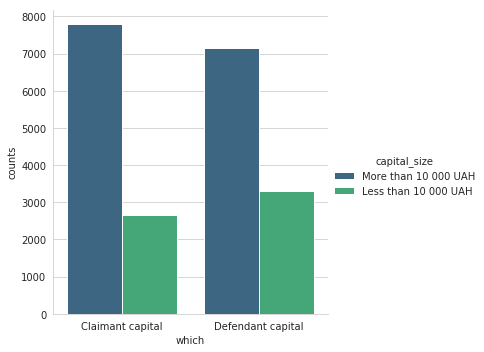

In [63]:
# now let's look into our capitals data
# because we have some too large anomaly capitals, instead of histogram we'll use bar plot, separating capitals into two groups
# not that I've expected to see, we have many more samples with capitals larger than 10 000
# maybe it's connected to the fact that usually small companies not so often are willing to participate in a trial
# but another reason may be that we somehow extracted more those values with larger capitals (more probable)


claimant_cap = pd.Series(np.where(court_data.claimant_capital > 10000, 'More than 10 000 UAH', 'Less than 10 000 UAH'))
defendant_cap = pd.Series(np.where(court_data.defendant_capital > 10000, 'More than 10 000 UAH', 'Less than 10 000 UAH'))

combined_cap = pd.melt(pd.DataFrame({'Claimant capital': claimant_cap, 'Defendant capital': defendant_cap}), 
                       var_name='which', value_name='capital_size')
combined_cap = combined_cap.groupby('which').capital_size.value_counts().to_frame('counts').reset_index()

sns.catplot(x='which', hue='capital_size', y='counts', data=combined_cap, kind='bar', palette='viridis');

In [15]:
# now we need function to extract outcomes

def get_outcome(row):
    try:
        
        doc_id = row.id
        outcomes_list = [case for case in row.outcomeFull if float(case['id']) == doc_id][0]['outcomeFull']

        outcome = 0

        for i in outcomes_list:
            if i in ['Відмовлено у задоволенні скарги', 'Рішення залишено без змін', 'Відмовлено у задоволенні позову']:
                outcome += 0
            elif i in ['Позов задоволено', 'Скарга задоволена', 'Позов задоволено частково', 'Накладено стягнення']:
                outcome += 1
        
        if outcome >= 2: # to handle cases like  ['Позов задоволено частково', 'Скарга задоволена']
                        # was == 2, but not > 2 to handle cases like ['Позов задоволено', 'Скарга задоволена', 'Накладено стягнення']
            outcome = 1
        return outcome
    
    except IndexError:
        
        return None

In [13]:
court_data['outcome'] = court_data.apply(get_outcome, axis=1)

In [15]:
court_data.dropna(subset=['outcome'], inplace=True)
court_data.shape

(10448, 21)

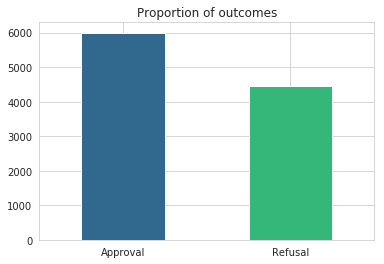

In [69]:
# seems like there are more positive decisions than negative
# further we need to compare this proportion with proportion in larger dataset without capitals to see they match

with sns.color_palette('viridis', n_colors=2):
    court_data.outcome.map({0: 'Refusal', 1: 'Approval'}).value_counts().plot.bar(title='Proportion of outcomes')
    plt.xticks(rotation=0);

In [18]:
filtered_df = court_data.copy()

In [31]:
# now we wan't to extract sex of each judge

def get_judge_sex(row):
    try:
        stemmed_names = []
        for name in row.judges_names:
            shorten = ' '.join([j[0]+'.' if i == 1 or i == 2 else j for i, j in enumerate(name.split())])
            stemmed_names.append(shorten)

        idx = [stemmed_names.index(judge) for judge in stemmed_names if judge[:-3]+judge[-2:] == row.judge][0]

        return 0 if row.sex[idx] == 'чоловік' else 1
    
    except IndexError:
        return None

In [ ]:
court_data

In [17]:
# actually here we're dropping 990 of our values
# if further we'll see that this feature along with sex, is not usefull, we should come back here and not drop these values
# filtered_df = court_data.dropna(subset=['judges_names'])

In [18]:
# filtered_df['judges_names'] = filtered_df.judges_names.apply(ast.literal_eval)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
# filtered_df = filtered_df[~filtered_df['sex'].isin(['[null]'])]

# filtered_df['sex'] = filtered_df.sex.apply(lambda x: x.replace('null', '"null"')).apply(ast.literal_eval)

# filtered_df['bin_sex'] = filtered_df.apply(get_judge_sex, axis=1)

# filtered_df.dropna(subset=['bin_sex'], inplace=True)

In [20]:
# # only 8k+ are left
# filtered_df.shape

(8486, 22)

In [14]:
# now we wan't to count our parties - how much times they already been involved in a trial

def get_party_count(row, kind, data):
    if kind == 'claimant':
        return data.claimant_split.isin([row]).sum()
    
    elif kind == 'defendant':
        return data.defendant_split.isin([row]).sum()
    
    else:
        return data.claimant_split.isin([row]).sum() + data.defendant_split.isin([row]).sum()

In [19]:
# cutting our strings with parties to better match when count

filtered_df['claimant_split'] = filtered_df.claimant.apply(lambda x: ' '.join([i[:3].upper().replace(',', '') if '"' not in i else i.upper().replace(',', '') for i in x.split()]))
filtered_df['defendant_split'] = filtered_df.defendant.apply(lambda x: ' '.join([i[:3].upper().replace(',', '') if '"' not in i else i.upper().replace(',', '') for i in x.split()]))

In [ ]:
# applying our function

filtered_df['claimant_as_claimant'] = filtered_df.claimant_split.apply(get_party_count, kind='claimant', data=filtered_df)
filtered_df['claimant_as_defendant'] = filtered_df.claimant_split.apply(get_party_count, kind='defendant', data=filtered_df)
filtered_df['claimant_overall'] = filtered_df.claimant_split.apply(get_party_count, kind='overall', data=filtered_df)

filtered_df['defendant_as_claimant'] = filtered_df.claimant_split.apply(get_party_count, kind='claimant', data=filtered_df)
filtered_df['defendant_as_defendant'] = filtered_df.claimant_split.apply(get_party_count, kind='defendant', data=filtered_df)
filtered_df['defendant_overall'] = filtered_df.claimant_split.apply(get_party_count, kind='overall', data=filtered_df)

In [23]:
# next we'll extract the dayofweek of a trial
# for some reason the date is off for one day, so we need to manually fix that by adding an offset

from pandas.tseries.offsets import Day

def get_time(row):
    try:
    
        date = pd.to_datetime([case['lawsuitDate'] for case in row.outcomeFull if row.id == float(case['id'])][0]) + Day()
    
        return date.dayofweek
    
    except IndexError:
        return None

In [36]:
filtered_df['dayofweek'] = filtered_df.apply(get_time, axis=1)

In [25]:
# loading previously extracted data that has duration in days for each case

durations_df = pd.read_csv('duration_df.csv')

In [37]:
filtered_df = pd.merge(filtered_df, durations_df, left_on=['cause_num', 'instance'], right_on=['cause_num', 'name_y'])

In [38]:
filtered_df['duration_days'] = filtered_df.adjudication_date_y.str.extract(r'(\d+)\sdays')[0].astype(int)

In [30]:
filtered_df['duration_days'].head()

0    361
1     97
2     97
3     98
4    328
Name: duration_days, dtype: int64

In [31]:
# saving our reduced df to compare then with those where judges sex not counted

reduced_df = filtered_df.copy()

In [107]:
# all_court_data = pd.read_csv('court_features_v3.csv')

In [11]:
# all_court_data['parties'] = all_court_data.cleaned.apply(ast.literal_eval)
# all_court_data['outcomeFull'] = all_court_data.outcomeFull.apply(ast.literal_eval)

# del all_court_data['cleaned']

all_court_data['id'] = all_court_data['id'].apply(int)

In [63]:
# all_court_data['claimant'] = all_court_data.parties.apply(get_one_party, kind='claimant')
# all_court_data['defendant'] = all_court_data.parties.apply(get_one_party, kind='defendant')

# all_court_data.dropna(subset=['claimant', 'defendant'], inplace=True)

# all_court_data['n_claimants'] = all_court_data['claimant'].apply(lambda x: x[1])
# all_court_data['claimant'] = all_court_data['claimant'].apply(lambda x: x[0])

# all_court_data['n_defendants'] = all_court_data['defendant'].apply(lambda x: x[1])
# all_court_data['defendant'] = all_court_data['defendant'].apply(lambda x: x[0])

In [16]:
all_court_data['outcome'] = all_court_data.apply(get_outcome, axis=1)

In [17]:
all_court_data.shape

(70440, 19)

In [18]:
all_court_data['claimant_split'] = all_court_data.claimant.apply(lambda x: ' '.join([i[:3].upper().replace(',', '') if '"' not in i else i.upper().replace(',', '') for i in x.split()]))
all_court_data['defendant_split'] = all_court_data.defendant.apply(lambda x: ' '.join([i[:3].upper().replace(',', '') if '"' not in i else i.upper().replace(',', '') for i in x.split()]))

all_court_data['claimant_as_claimant'] = all_court_data.claimant_split.apply(get_party_count, kind='claimant', data=all_court_data)
all_court_data['claimant_as_defendant'] = all_court_data.claimant_split.apply(get_party_count, kind='defendant', data=all_court_data)
all_court_data['claimant_overall'] = all_court_data.claimant_split.apply(get_party_count, kind='overall', data=all_court_data)

all_court_data['defendant_as_claimant'] = all_court_data.claimant_split.apply(get_party_count, kind='claimant', data=all_court_data)
all_court_data['defendant_as_defendant'] = all_court_data.claimant_split.apply(get_party_count, kind='defendant', data=all_court_data)
all_court_data['defendant_overall'] = all_court_data.claimant_split.apply(get_party_count, kind='overall', data=all_court_data)

In [28]:
# all_court_data['dayofweek'] = all_court_data.apply(get_time, axis=1)
all_court_data = pd.merge(all_court_data, durations_df, left_on=['cause_num', 'instance'], right_on=['cause_num', 'name_y'])
all_court_data['duration_days'] = all_court_data.adjudication_date_y.str.extract(r'(\d+)\sdays')[0].astype(int)

all_court_data.dropna(subset=['dayofweek'], inplace=True)

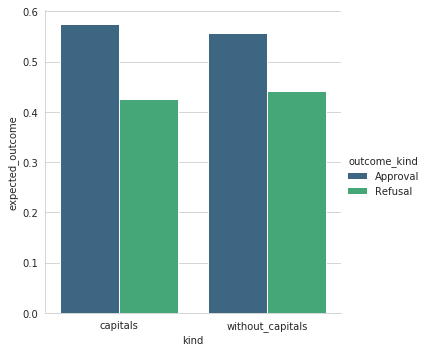

In [120]:
# going back and checking if both dataset (smaller and larger) match

capitals = filtered_df.outcome.map({0: 'Refusal', 1: 'Approval'}).value_counts(normalize=True).reset_index()

without_capitals = all_court_data.outcome.map({0: 'Refusal', 1: 'Approval'}).value_counts(normalize=True).reset_index()

both = pd.concat([capitals, without_capitals], keys=['capitals', 'without_capitals'])\
                                                        .reset_index(0).rename({'level_0': 'kind',
                                                                                'index': 'outcome_kind',
                                                                                'outcome': 'expected_outcome'}, axis=1)

sns.catplot(x='kind', hue='outcome_kind', y='expected_outcome', data=both, kind='bar', palette='viridis');

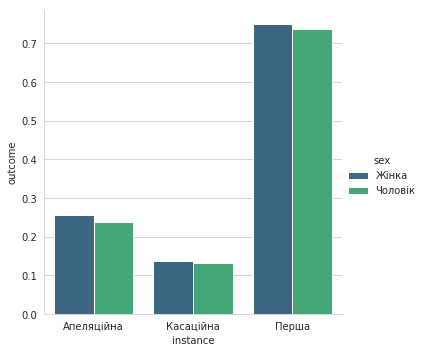

In [141]:
all_court_data['sex'] = data_bs_reduced.bin_sex.map({0: 'Чоловік', 1: 'Жінка'})

sns.catplot(x='instance', hue='sex', y='outcome',
            data=all_court_data.groupby(['instance', 'sex']).outcome.mean().reset_index(), 
            kind='bar', palette='viridis');

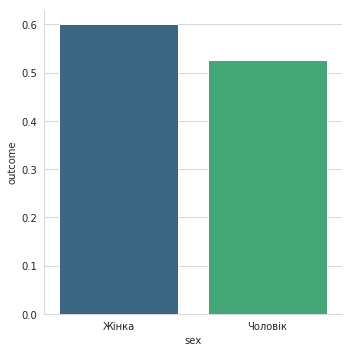

In [143]:
sns.catplot(x='sex', y='outcome',
            data=all_court_data.groupby('sex').outcome.mean().reset_index(), kind='bar', palette='viridis');

In [280]:
# summed difference for all instances

all_court_data.groupby(['instance', 'bin_sex']).outcome.mean().reset_index()\
            .groupby('instance').outcome.apply(lambda x: x.iloc[1] - x.iloc[0]).sum()

0.03201589144103395

In [279]:
# without group by instances, overall difference, they don't match
# how that possible? Kind of Simpson paradox?

all_court_data.groupby(['bin_sex']).outcome.mean().reset_index().outcome.diff().max()

0.07489063867016621

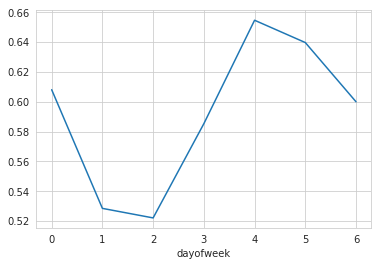

In [290]:
# Thursday is luckiest day, 5 and 6 are Fridays and Thursday - there are very few trials at all
# probably it's because Thursday has less cases overall

all_court_data.groupby('dayofweek').outcome.mean().plot();

In [148]:
# and this is indeed True, Thursday just happen to have much less cases

all_court_data.groupby('dayofweek').outcome.count()

dayofweek
0.0    14123
1.0    20207
2.0    15020
3.0    15617
4.0     4156
5.0      180
6.0       12
Name: outcome, dtype: int64

### Final preparations and saving into files

In [85]:
sample_all_data = all_court_data[all_court_data.id.isin(filtered_df.id)].copy()

In [29]:
# saving our datasets

filtered_df.drop(['adjudication_date_y'], axis=1).to_csv('most_recent/data_with_capitals.csv', index=False)
all_court_data.drop(['adjudication_date_y'], axis=1).to_csv('most_recent/data_full.csv', index=False)

In [ ]:
# optional

# all_court_data = pd.read_csv('most_recent/data_full.csv')

all_court_data = all_court_data.dropna(subset=['judges_names'])

all_court_data['judges_names'] = all_court_data.judges_names.apply(ast.literal_eval)

all_court_data = all_court_data[~all_court_data['sex'].isin(['[null]'])]

all_court_data['sex'] = all_court_data.sex.apply(lambda x: x.replace('null', '"null"')).apply(ast.literal_eval)

all_court_data['bin_sex'] = all_court_data.apply(get_judge_sex, axis=1)

all_court_data.dropna(subset=['bin_sex'], inplace=True)

all_court_data.to_csv('most_recent/data_full_bs_reduced.csv')